In [43]:
import pandas as pd
import glob
import json 
import numpy as np
from pandarallel import pandarallel
import requests
# Initialization
pandarallel.initialize(nb_workers=4, use_memory_fs=False)
import matplotlib.pyplot as plt

pd.options.display.width = 150

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
GOOGLE_API= ""
with open("Google_api_key.txt", 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            GOOGLE_API = f.read().strip()

### Concatenante the data 
from the Logic App workflow, we get several json file, hence need to concatenate all together

In [3]:
# concatenate the json files

df = pd.read_json('./Data/WithCoordinates_Finnyeardata_WholeNorway/WithCoordinates_1987_Finnyeardata_WholeNorway_1987_label_7.json')

In [41]:
df.head()

,Location,ad_id,ad_link,energy_label,lat,lon,property_type_description,size_from,type,byggear_cat,ownership_cat,"lat,lon"
0,"Olsvikåsen 132, Olsvik",261320756,https://www.finn.no/realestate/homes/ad.html?f...,5,60.38086,5.22157,Leilighet,47.0,realestate,1,2,"60.38086,5.22157"
1,"Hans Haslums Vei 33, Bekkestua",261047389,https://www.finn.no/realestate/homes/ad.html?f...,5,59.91960,10.57280,Enebolig,359.0,realestate,1,1,"59.9196,10.5728"
2,"Oskarbakken 21, Mo i Rana",260995104,https://www.finn.no/realestate/homes/ad.html?f...,5,66.29020,14.09350,Enebolig,153.0,realestate,1,1,"66.2902,14.0935"
3,"Sandalssvingen 7, Stavanger",260891920,https://www.finn.no/realestate/homes/ad.html?f...,5,58.95740,5.68380,Leilighet,47.0,realestate,1,2,"58.9574,5.6838"
4,"Midtåstunet 8, Førde",260886553,https://www.finn.no/realestate/homes/ad.html?f...,5,61.45764,5.90090,Rekkehus,99.0,realestate,1,2,"61.45764,5.9009"


In [5]:
data = []

for f in glob.glob("./Data/WithCoordinates_Finnyeardata_WholeNorway/*.json"):

    with open(f,) as infile:

        data.extend(json.load(infile))


with open("merged_file.json",'w') as outfile:

    json.dump(data, outfile)



In [6]:
len(data)

6961

### Data Cleaning

In [7]:
df = pd.DataFrame(data)

In [8]:
df.head()

,Location,ad_id,ad_link,ad_type,energy_label,from_year,lat,local_area_name,lon,number_of_bedrooms,owner_type_description,property_type_description,size_from,to_year,type
0,"Olsvikåsen 132, Olsvik",261320756,https://www.finn.no/realestate/homes/ad.html?f...,1,5,1979,60.38086,Bergen Vest/Olsvik,5.22157,1,Andel,Leilighet,47.0,1979,realestate
1,"Hans Haslums Vei 33, Bekkestua",261047389,https://www.finn.no/realestate/homes/ad.html?f...,1,5,1979,59.91960,DESIGNBOLIG PÅ BEKKESTUA,10.57280,6,Eier (Selveier),Enebolig,359.0,1979,realestate
2,"Oskarbakken 21, Mo i Rana",260995104,https://www.finn.no/realestate/homes/ad.html?f...,1,5,1979,66.29020,Åga,14.09350,5,Eier (Selveier),Enebolig,153.0,1979,realestate
3,"Sandalssvingen 7, Stavanger",260891920,https://www.finn.no/realestate/homes/ad.html?f...,1,5,1979,58.95740,SANDAL,5.68380,1,Andel,Leilighet,47.0,1979,realestate
4,"Midtåstunet 8, Førde",260886553,https://www.finn.no/realestate/homes/ad.html?f...,1,5,1979,61.45764,None,5.90090,3,Andel,Rekkehus,99.0,1979,realestate


### keep only the private housing: 

In the current dataset there is 'Leilighet', 'Leilighet', 'Rekkehus', 'Tomannsbolig',
       'Gårdsbruk/Småbruk', 'Bygård/Flermannsbolig', 'Andre',
       'Produksjon/Industri', 'Annet fritid', 'Garasje/Parkering'
       
** We keep only Leilighet, Enebolig, Rekkehus, Tomannsbolig.**

In [9]:
for element in ['Gårdsbruk/Småbruk', 'Bygård/Flermannsbolig', 'Andre', 
       'Produksjon/Industri', 'Annet fritid', 'Garasje/Parkering']:
    df.drop(df[df['property_type_description']==element].index,inplace=True)

In [10]:
df['property_type_description'].value_counts()

Leilighet       3301
Enebolig        2711
Tomannsbolig     460
Rekkehus         385
Name: property_type_description, dtype: int64

In [11]:
df['owner_type_description'].value_counts()

Eier (Selveier)    5352
Andel              1445
Aksje                59
Obligasjon            1
Name: owner_type_description, dtype: int64

## energy labels 

dict ={'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7}

<AxesSubplot:>

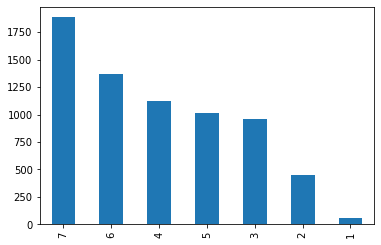

In [12]:
df['energy_label'].value_counts().plot.bar()

### Categorization of the ads by the year of the building

- The baseline correlation is -0.736159 between the year of the building and the energy label 
- we increase it to 75% if define a cut off on 1901 and categorising by 5 years 
- cut off ≈ 1950 / 1960 => 82% and then need to play with the categorization ( 1 to 10 years ? )

**TEK**
In Norway the laws for the buildings were: TEK69 TEK87, TEK97,TEK07,TEK10, TEK17

In [13]:
def CategoriseBuilding(year):
    if year < 1969:
        byggear_cat = 0
    elif year < 1987:
        byggear_cat = 1
    elif year < 1997:
        byggear_cat = 2
    elif year < 2007:
        byggear_cat = 3
    elif year < 2010:
        byggear_cat = 4
    elif year < 2017:
        byggear_cat = 5
    elif year >= 2017:
        byggear_cat = 6
        
    return byggear_cat


In [14]:
df['byggear_cat'] = df['to_year'].apply(lambda x: CategoriseBuilding(x))

In [15]:
df2= pd.DataFrame(df['byggear_cat'].value_counts())

In [16]:
df2 = df2.sort_index()

In [17]:
df2= df2.rename(index={0:'no TEK',1:'TEK69',2:'TEK87',3:'TEK97',4:'TEK07',5:'TEK10',6:'TEK17'})

<AxesSubplot:title={'center':'proportion of ads in the dataset based on TEK laws'}>

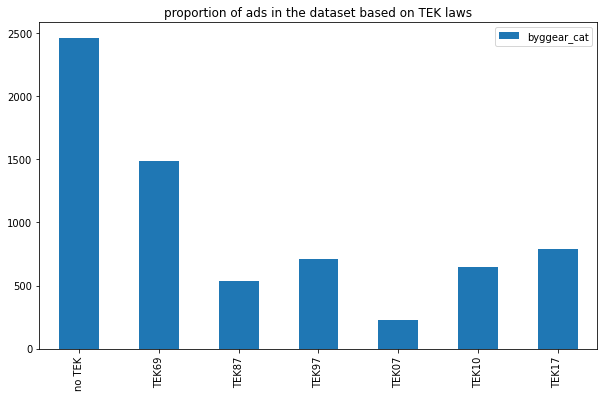

In [18]:
df2.plot.bar(figsize=(10,6),title='proportion of ads in the dataset based on TEK laws')

###  analysis of the energy label population within the different TEKsubsets

In [19]:
df_pivot = pd.DataFrame(pd.pivot_table(df,values=['energy_label'], index='byggear_cat',aggfunc='value_counts',sort='energy_label'))

In [20]:
df_pivot = df_pivot.sort_values(['byggear_cat','energy_label'])

In [21]:
df_pivot.head(10)

0
byggear_cat energy_label      
0           1                1
            2               14
            3               52
            4               84
            5              146
            6              549
            7             1618
1           1                1
            2                9
            3               12

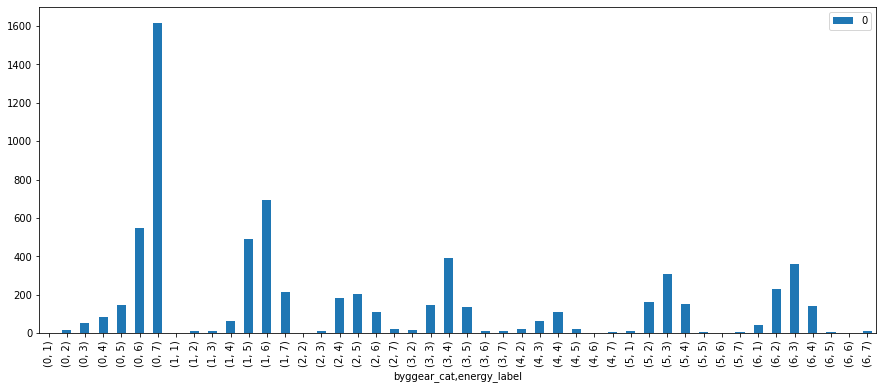

In [22]:
df_pivot.plot.bar(figsize=(15,6))
plt.savefig('test.pdf')

#####  anomalies investigation
e.g.
- (0,2): no TEK and energy label B: apartment or houses renovert
- (6,5): TEK17 and label E: poor isolated building
- (6,7): TEk17 and label G: maybe one fully renovert the rest is new buildings 

In [23]:
temp_df = df[df['byggear_cat']==6]

In [24]:
temp_df[temp_df['energy_label']==7].ad_link

118     https://www.finn.no/realestate/homes/ad.html?f...
120     https://www.finn.no/realestate/homes/ad.html?f...
121     https://www.finn.no/realestate/homes/ad.html?f...
122     https://www.finn.no/realestate/homes/ad.html?f...
123     https://www.finn.no/realestate/homes/ad.html?f...
6957    https://www.finn.no/realestate/homes/ad.html?f...
6958    https://www.finn.no/realestate/homes/ad.html?f...
6959    https://www.finn.no/realestate/homes/ad.html?f...
6960    https://www.finn.no/realestate/homes/ad.html?f...
Name: ad_link, dtype: object

In [25]:
df.isnull().sum()

Location                        0
ad_id                           0
ad_link                         0
ad_type                         0
energy_label                    0
from_year                       0
lat                             0
local_area_name              2194
lon                             0
number_of_bedrooms              0
owner_type_description          0
property_type_description       0
size_from                       1
to_year                         0
type                            0
byggear_cat                     0
dtype: int64

## Improve the correlation building's year and energy label

In [26]:
corr_global = df.corr()['energy_label']['byggear_cat']
#correlation year building vs energy label in function of the type of buildings

corr_energy_labels_vs_type_ads=[]
for type_ads in df['property_type_description'].unique():
    local_corr = df[df['property_type_description'] == type_ads].corr()['energy_label']['byggear_cat']
    corr_energy_labels_vs_type_ads.append(abs(local_corr))
    
labels = df['property_type_description'].unique()

In [27]:
df_correlation= pd.DataFrame({'Type_Announces':labels,'Correlation':corr_energy_labels_vs_type_ads})

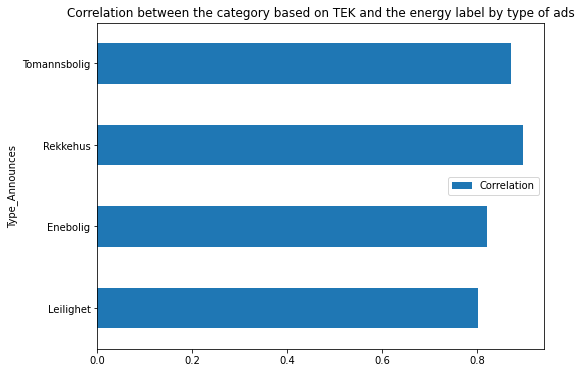

In [28]:
df_correlation.plot.barh(x='Type_Announces',y='Correlation',figsize=(8,6),title='Correlation between the category based on TEK and the energy label by type of ads')
plt.savefig('correlation_by_type_building.pdf')

In [29]:
df.corr()

,ad_id,ad_type,energy_label,from_year,lat,lon,number_of_bedrooms,size_from,to_year,byggear_cat
ad_id,1.000000,NaN,0.036030,-0.029159,-0.125344,-0.044342,-0.049499,-0.047328,-0.029159,-0.053178
ad_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
energy_label,0.036030,NaN,1.000000,-0.741742,0.052593,0.065122,0.077613,0.099158,-0.741742,-0.824377
from_year,-0.029159,NaN,-0.741742,1.000000,-0.005621,-0.027600,-0.048268,-0.079370,1.000000,0.843230
lat,-0.125344,NaN,0.052593,-0.005621,1.000000,0.705493,0.054721,0.004307,-0.005621,-0.051280
lon,-0.044342,NaN,0.065122,-0.027600,0.705493,1.000000,0.002025,-0.012964,-0.027600,-0.056868
number_of_bedrooms,-0.049499,NaN,0.077613,-0.048268,0.054721,0.002025,1.000000,0.748565,-0.048268,-0.095847
size_from,-0.047328,NaN,0.099158,-0.079370,0.004307,-0.012964,0.748565,1.000000,-0.079370,-0.153589
to_year,-0.029159,NaN,-0.741742,1.000000,-0.005621,-0.027600,-0.048268,-0.079370,1.000000,0.843230
byggear_cat,-0.053178,NaN,-0.824377,0.843230,-0.051280,-0.056868,-0.095847,-0.153589,0.843230,1.000000


### Impact of the ownership

In [30]:
dict_ownership = {'Eier (Selveier)':1,'Andel':2,'Aksje':3,'Obligasjon':4}

In [31]:
df['ownership_cat'] = df['owner_type_description'].map(dict_ownership)

## Get Elevation

In [32]:
def GetElevation(coordinates):
    lat, lon = coordinates.split(',')
    url = f"https://maps.googleapis.com/maps/api/elevation/json?locations={lat},{lon}&key={GOOGLE_API}"

    payload={}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)
    #print(response.text)
    response=response.json()
    return response['results'][0]['elevation']

df['lat,lon'] = df['lat'].astype(str)+','+ df['lon'].astype(str)

#RUN ONLY if needed, takes 20min ( 8 ads per seconds)
#df['elevation'] = df['lat,lon'].apply(lambda x: GetElevation(x))



## Removing features



In [33]:
df.columns

Index(['Location', 'ad_id', 'ad_link', 'ad_type', 'energy_label', 'from_year',
       'lat', 'local_area_name', 'lon', 'number_of_bedrooms',
       'owner_type_description', 'property_type_description', 'size_from',
       'to_year', 'type', 'byggear_cat', 'ownership_cat', 'lat,lon'],
      dtype='object')

In [34]:
df.drop(['from_year','to_year','number_of_bedrooms','ad_type','owner_type_description','local_area_name'],axis=1, inplace = True)

## output

df.to_csv('output_cleaning_step.csv')